<h2>Содержание<span class="tocSkip"></span></h2>
<p> </p>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Предобработка-данных" data-toc-modified-id="1-Предобработка-данных"><span class="toc-item-num"></span>1 Предобработка данных</a></span></li><li><span><a href="#2-Функции-для-расчета-и-анализа-LTV,-ROI,-удержания-и-конверсии" data-toc-modified-id="2-Функции-для-расчета-и-анализа-LTV,-ROI,-удержания-и-конверсии"><span class="toc-item-num"></span>2 Функции для расчета и анализа LTV, ROI, удержания и конверсии</a></span></li><li><span><a href="#3-Исследовательский-анализ-данных" data-toc-modified-id="3-Исследовательский-анализ-данных"><span class="toc-item-num"></span>3 Исследовательский анализ данных</a></span></li><li><span><a href="#4-Анализ-затрат-на-маркетинг" data-toc-modified-id="4-Анализ-затрат-на-маркетинг"><span class="toc-item-num"></span>4 Анализ затрат на маркетинг</a></span></li><li><span><a href="#5-Оценка-окупаемости-рекламы-для-привлечения-пользователей" data-toc-modified-id="5-Оценка-окупаемости-рекламы-для-привлечения-пользователей"><span class="toc-item-num"></span>5 Оценка окупаемости рекламы для привлечения пользователей</a></span></li><li><span><a href="#6-Общий-вывод" data-toc-modified-id="6-Общий-вывод"><span class="toc-item-num"></span>6 Общий вывод

# Описание проекта

Владельцы развлекательного приложения Procrastinate Pro+ в течение нескольких месяцев вкладывали большие денежные средства в рекламу для привлечения пользователей, но вместо прибыли бизнес терпит убытки.

Необходимо разобраться в причинах и выявить факторы, отрицательно влияющие на окупаемость рекламы.

В распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. 

Изучим, как люди пользуются продуктом, сколько денег приносят компании, чтобы помочь компании выйти в "плюс".

## 1 Предобработка данных

In [1]:
#Импортируем все необходимые библиотеки
import pandas as pd 
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
visits, orders, costs = (
    pd.read_csv('visits_info_short.csv'),  # журнал сессий
    pd.read_csv('orders_info_short.csv'),  # покупки
    pd.read_csv('costs_info_short.csv'),  # траты на рекламу
)

In [3]:
visits.info() #посмотрим информацию от датасете visits

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end'] #приведем название столбцов к нижнему регистру

In [5]:
orders.info() #посмотрим информацию от датасете orders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [6]:
orders.columns = ['user_id', 'event_dt', 'revenue'] #приведем название столбцов к нижнему регистру

In [7]:
costs.info() #посмотрим информацию от датасете visits

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [8]:
costs.columns = ['dt', 'channel', 'costs'] #приведем название столбцов к нижнему регистру

In [9]:
# преобразуем данные о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [10]:
#Проверим наличие дубликатов
print('Количество дубликатов в журнале сессий:', visits.duplicated().sum())
print('Количество дубликатов в покупках:', orders.duplicated().sum())
print('Количество дубликатов в затратах на рекламу:', costs.duplicated().sum())

Количество дубликатов в журнале сессий: 0
Количество дубликатов в покупках: 0
Количество дубликатов в затратах на рекламу: 0


**Вывод**

Датасеты загружены в переменные visits, orders, costs, что соответствует журналам сессий, покупкам и тратам на рекламу. Дубликатов в данных не найдено, так же как и пропущенных значений. Наименования столбцов приведены к одному стилю.

## 2 Функции для расчета и анализа LTV, ROI, удержания и конверсии


In [11]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [12]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [13]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [14]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [15]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [16]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [17]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [18]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## 3 Исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [19]:
# получим профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5)) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [20]:
# определим доступный интервал привлечения пользователей
min_analysis_date = profiles['dt'].min()
max_analysis_date =  profiles['dt'].max() 
print(min_analysis_date)
print(max_analysis_date)

2019-05-01
2019-10-27


Чтобы выяснить из каких стран приходят посетители, какими устройствами пользуются, по каким рекламным каналам пришли пользователи напишем функцию по построению сводных таблиц.

In [21]:
def percent_of_users(profiles, dimensions=[]):
    percents = profiles.pivot_table(index=dimensions, columns = 'payer', values='user_id', aggfunc='count')
    percents['amount_of_users'] = percents.sum(axis=1)
    percents['percent_of_payers, %'] = round(percents[1]/percents['amount_of_users']*100, 2)
    percents = percents.drop(columns=[0,1])
    percents = percents.reindex(percents['percent_of_payers, %'].sort_values(ascending=False).index)
    return percents

In [22]:
# Построим сводные таблицы с разбивкой по странам, устройствам и каналу привлечения
features = ['region', 'device', 'channel']
for feature in features:
    display(percent_of_users(profiles, dimensions = feature))

payer,amount_of_users,"percent_of_payers, %"
region,,
United States,100002,6.90
Germany,14981,4.11
UK,17575,3.98
France,17450,3.80


payer,amount_of_users,"percent_of_payers, %"
device,,
Mac,30042,6.36
iPhone,54479,6.21
Android,35032,5.85
PC,30455,5.05


payer,amount_of_users,"percent_of_payers, %"
channel,,
FaceBoom,29144,12.20
AdNonSense,3880,11.34
lambdaMediaAds,2149,10.47
TipTop,19561,9.60
RocketSuperAds,4448,7.91
WahooNetBanner,8553,5.30
YRabbit,4312,3.83
MediaTornado,4364,3.57
LeapBob,8553,3.06


Самое большое количество пользователей проживают в США, на эту же страну и приходится большая доля платящих пользователей.
Больше всего пользователей используют IPhone, но доля платящих пользователей немного выше у пользователей с Mac, чем с Iphone.
Количество пользователей, пришедших "органическим" путем, почти в два раза больше, чем через канал "FaceBoom", но качественных пользователей из "FaceBoom" намного выше, и доля платящих из этого источника лидирует над всеми остальными каналами. Немного уступают ему платящие пользователи из источников "AdNonSense" и "lambdaMediaAds". А вот пришедшие из источника "Organic", почти совсем не платят.

##  4 Анализ затрат на маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [23]:
#уберем канал organic из profiles, на привлечение пользователей из этого канала средства потрачены не были
profiles = profiles.query('channel != "organic"') 

In [24]:
print('Общая сумма расходов на маркетинг:', round(profiles['acquisition_cost'].sum(),2), '$')

Общая сумма расходов на маркетинг: 105497.3 $


In [25]:
#Посмотрим распределение этой суммы по источникам рекламы
(profiles
 .pivot_table(index='channel', values='acquisition_cost', aggfunc = 'sum')
 .sort_values(by = 'acquisition_cost', ascending = False))

,acquisition_cost
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


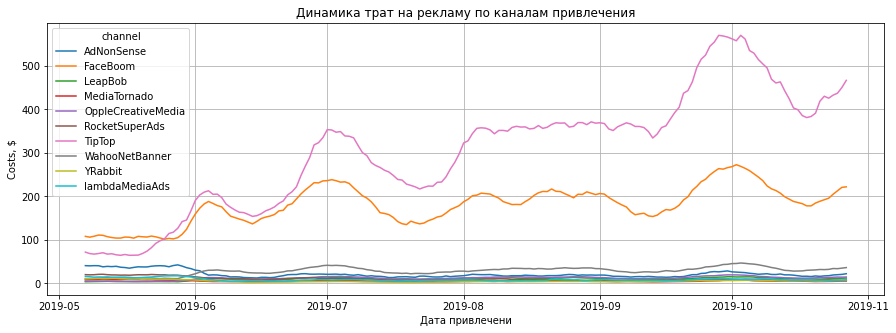

In [26]:
#Построим график динамики распределения трат по каналам привлечения
filtered_data = profiles.pivot_table(index='dt', columns = 'channel', values='acquisition_cost', aggfunc = 'sum')
filter_data(filtered_data, 7).plot(grid=True, figsize = (15,5))
plt.ylabel('Costs, $')
plt.xlabel('Дата привлечени')
plt.title('Динамика трат на рекламу по каналам привлечения')
plt.show()

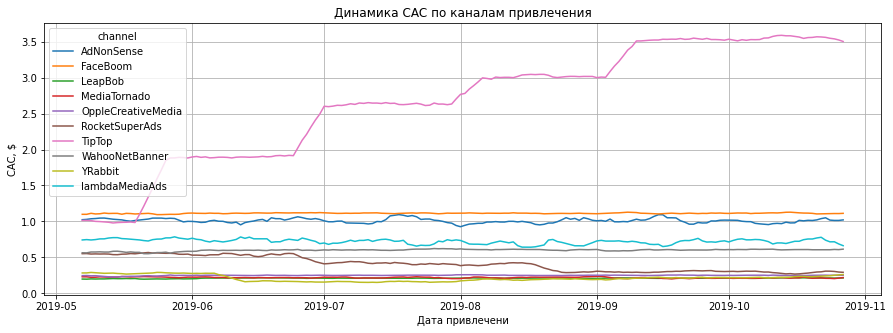

In [27]:
#Построим график динамики CAC по каналам привлечения
filtered_data = profiles.pivot_table(index='dt', columns = 'channel', values='acquisition_cost', aggfunc = 'mean')
filter_data(filtered_data, 7).plot(grid=True, figsize = (15,5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечени')
plt.title('Динамика CAC по каналам привлечения')
plt.show()

In [28]:
print('Средний CAC на одного пользователя для всего проекта:', 
      round(profiles['acquisition_cost'].sum()/profiles['user_id'].count(),2))

Средний CAC на одного пользователя для всего проекта: 1.13


In [29]:
#Рассчитаем средний CAC на одного пользователя для каждого источника трафика
(profiles
 .pivot_table(index='channel', values='acquisition_cost', aggfunc = 'mean')
 .sort_values(by = 'acquisition_cost', ascending = False))

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


**Выводы:**

На рекламу проекта было потрачено 105497$, чуть больше половины этой суммы пришлось на канал "TipTop" и 30%  от общей суммы было вложено в канал "FaceBoom". При этом вложения в "TipTop" в период с мая по октябрь 5 раз увеличивались и средний CAC в этом канале составил 2,8, в то время как по каналам "FaceBoom" и "AdNonSense" средний CAC составили 1,11 и 1 соответственно. А для всего проекта средний CAC составил 1,13.


## 5 Оценка окупаемости рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Проанализируем окупаемость рекламы с разбивкой по устройствам;
- Проанализируем окупаемость рекламы с разбивкой по странам;
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

При решении этого шага будем считать, что смотрим данные 1-го ноября 2019 года и что в организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

In [30]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # установим горизонт анализа 

### 5.1 Проанализируем общую окупаемость рекламы

In [31]:
# считаем LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

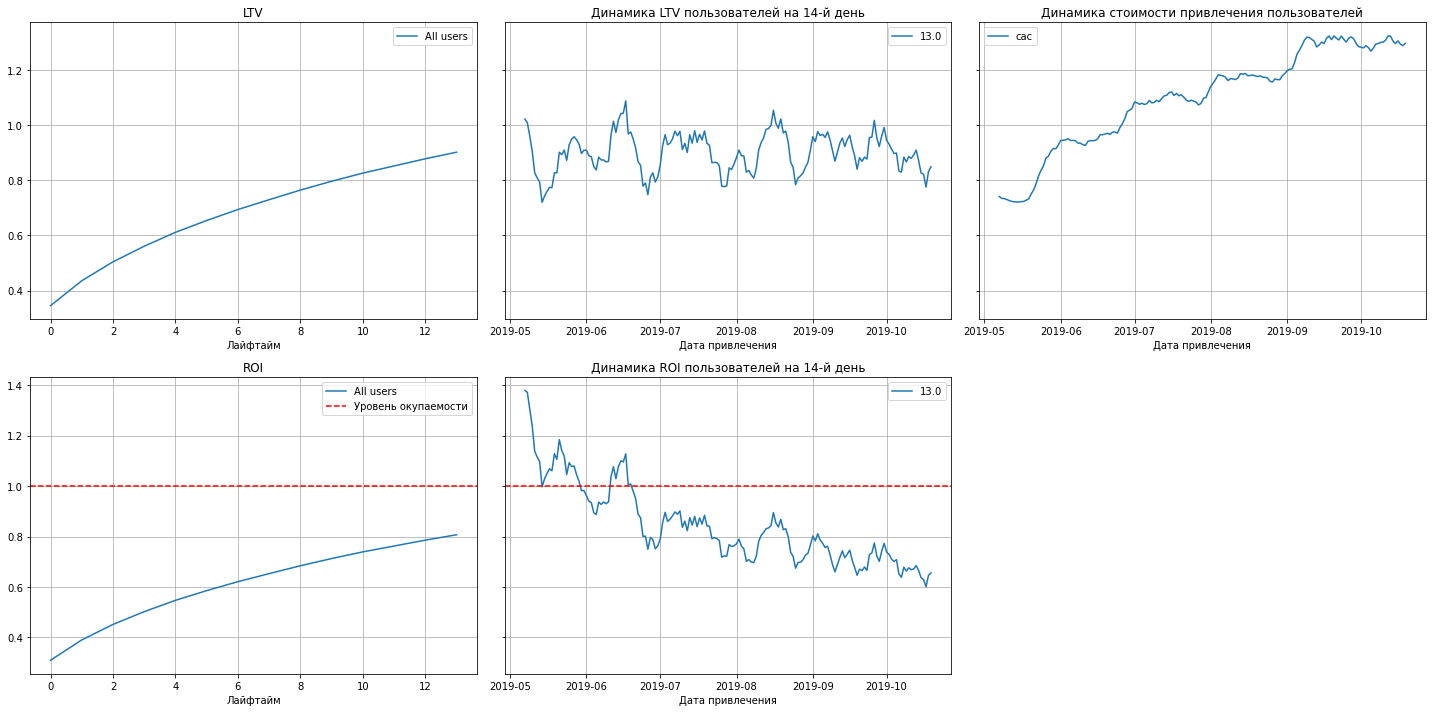

In [32]:
# строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

Реклама не окупается.
При этом CAC увеличивается. 
Окупаемость резко упала в июне, и далее пошла только по убывающей.
LTV достаточно стабилен, наблюдается некая закономерность в падении этого показателя в конце каждого месяца. 

### 5.2 Проанализируем окупаемость рекламы с разбивкой по устройствам

In [33]:
#Посмотрим окупаемость с разбивкой по устройствам
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

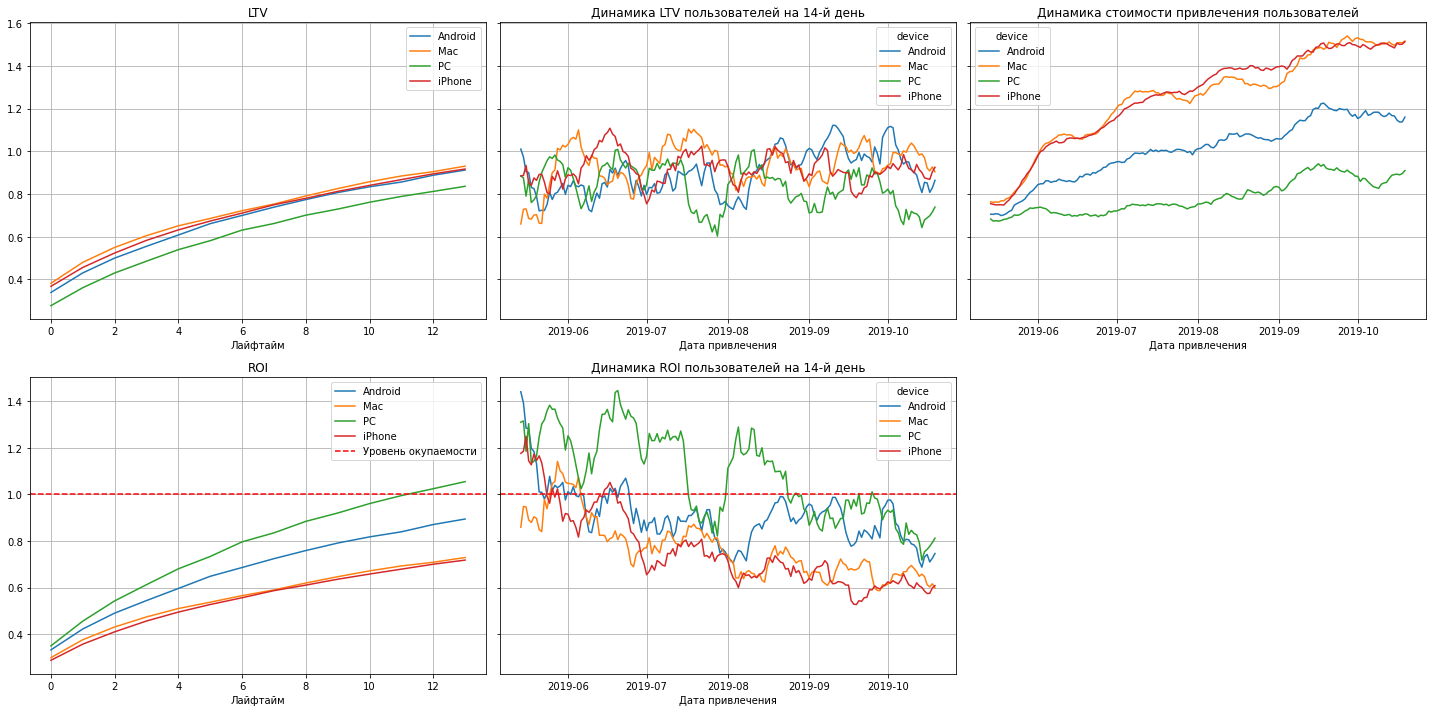

In [34]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

Из всех устройств окупается только PC. Рекламных средств на привлечение пользователей Mac и Iphone было вложено больше, и качественных пользователей там больше, но недостаточно, чтобы окупить вложения.

### 5.3 Проанализируем окупаемость рекламы с разбивкой по странам

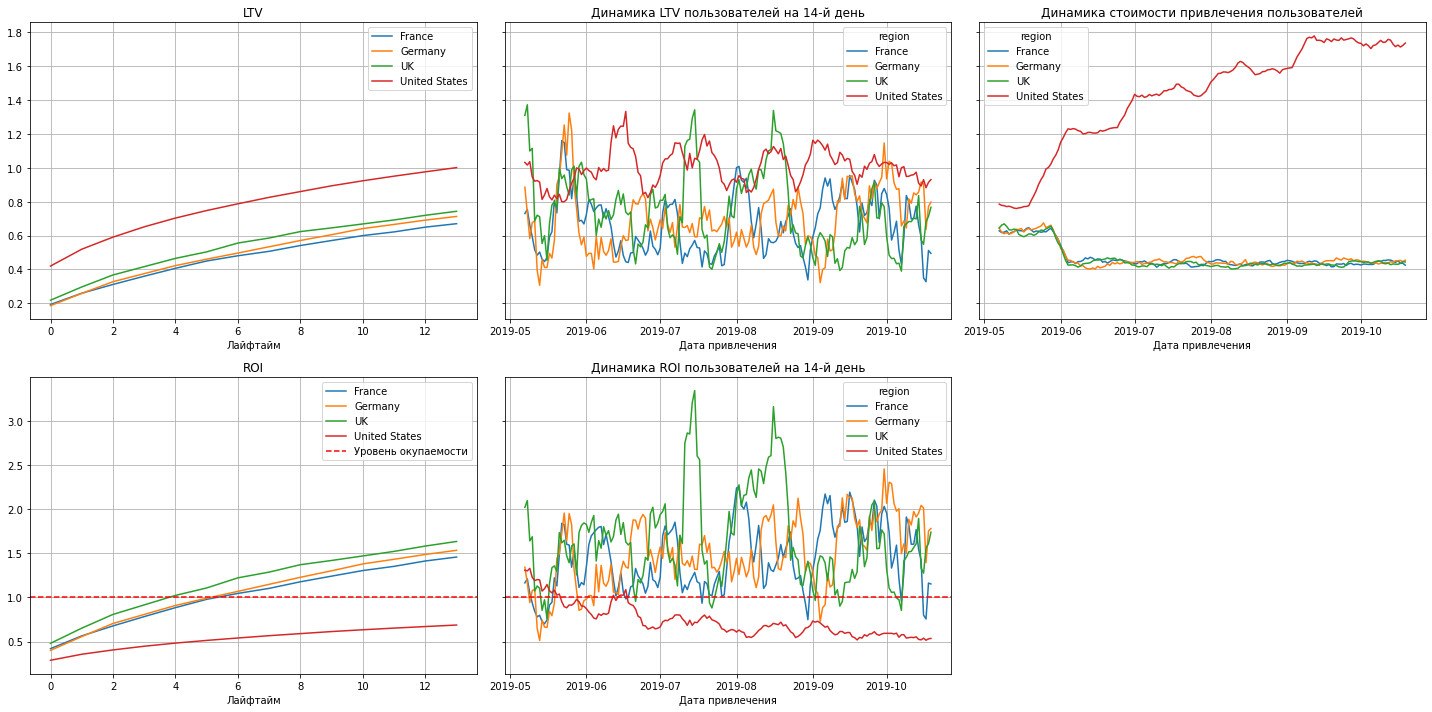

In [35]:
#Посмотрим окупаемость с разбивкой по странам

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions= ['region']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=7)

Если говорить про окупаемость по странам, то явный аутсайдер - это США. Опять же переломным месяцев стал июнь, именно после него окупаемость упала. Но вложений в рекламу для пользователей этой страны оказалось кратно больше, чем в других странах. 

### 5.4 Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

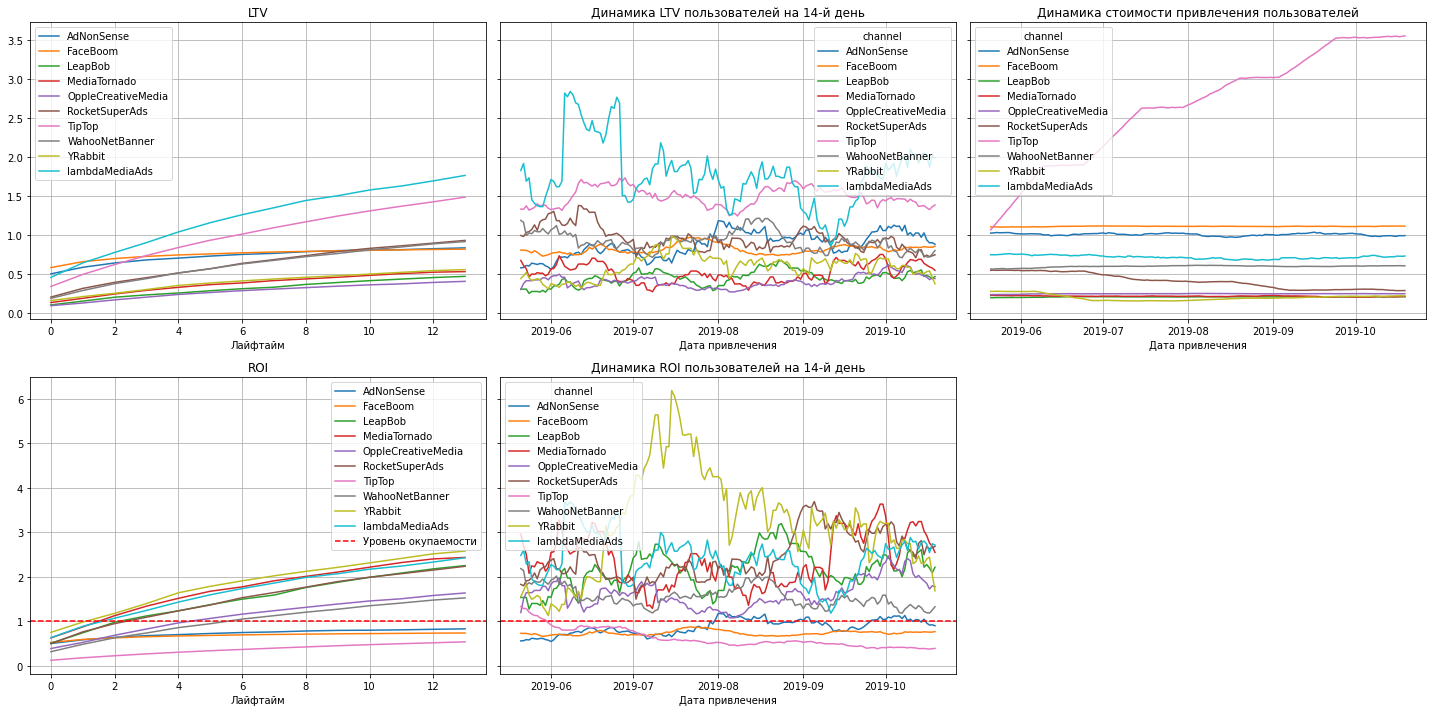

In [36]:
#Посмотрим окупаемость с разбивкой по источникам привлечения

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=21)

Более качественные пользователи пришли из каналов "lambdaMediaAds" и "TipTop", но рекламные вложения в "lambdaMediaAds" были стабильны и окупились, а вот вложения в "TipTop" не только не окупились, но еще и увеличивались каждый месяц. Также не окупились вложения в пользователей из каналов "FaceBoom" и "AdNonSense". Все остальные каналы окупились.

### 5.5 Построим графики конверсии и удержания

Узнаем в чем причина такой окупаемости, построим графики конверсии и удержания.

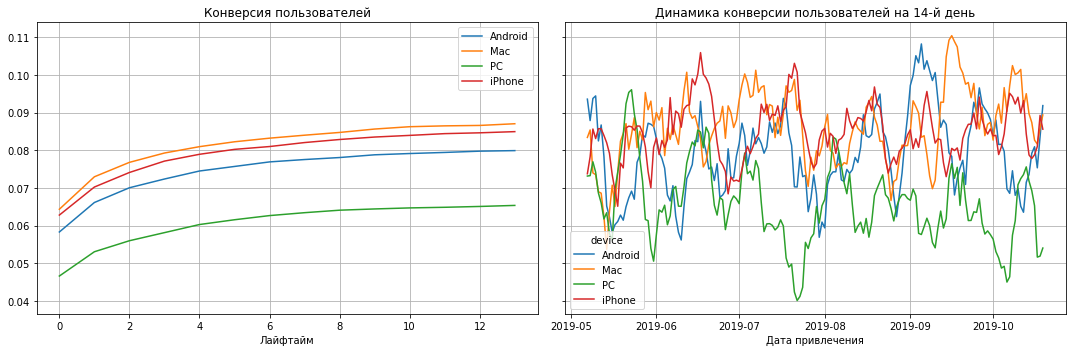

In [37]:
#Посмотрим конверсию с разбивкой по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions= ['device'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

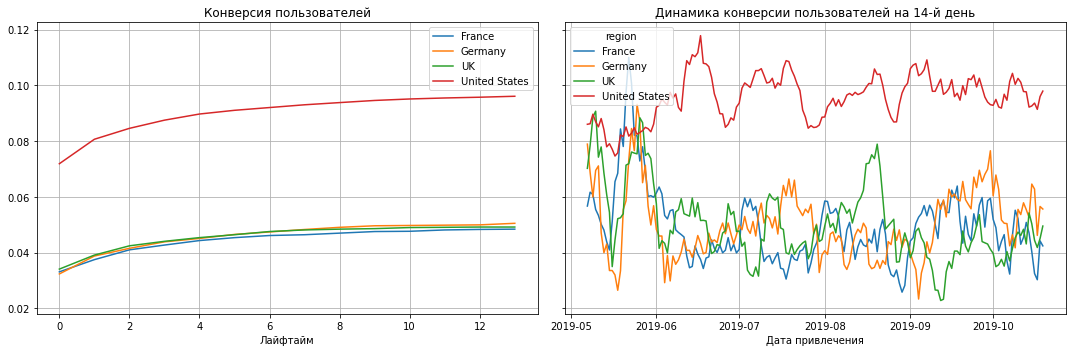

In [38]:
#Посмотрим конверсию с разбивкой по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions= ['region'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

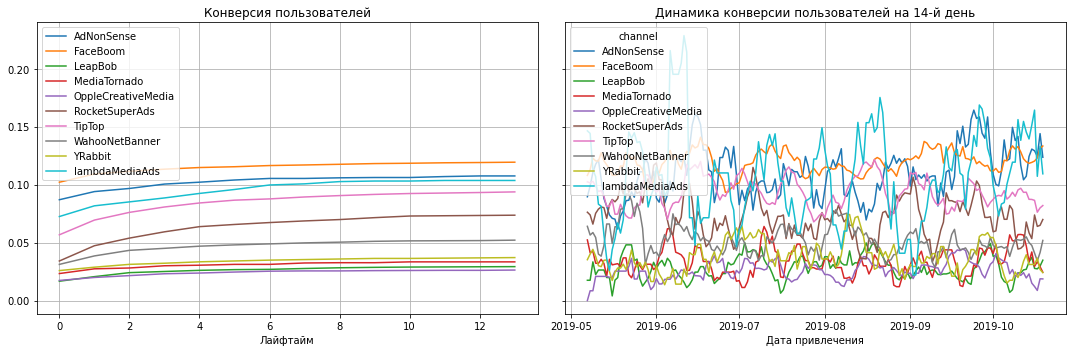

In [39]:
#Посмотрим конверсию с разбивкой по каналам привлечения
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions= ['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Пользователи из США конвертируются намного лучше других стран. То же самое можно сказать про пользователей с Mac и Iphone. Кроме того пользователи из канала "Faceboom" конвертировались лучше всех и стабильнее, хоть вложения в этот рекламный канал и не окупились.

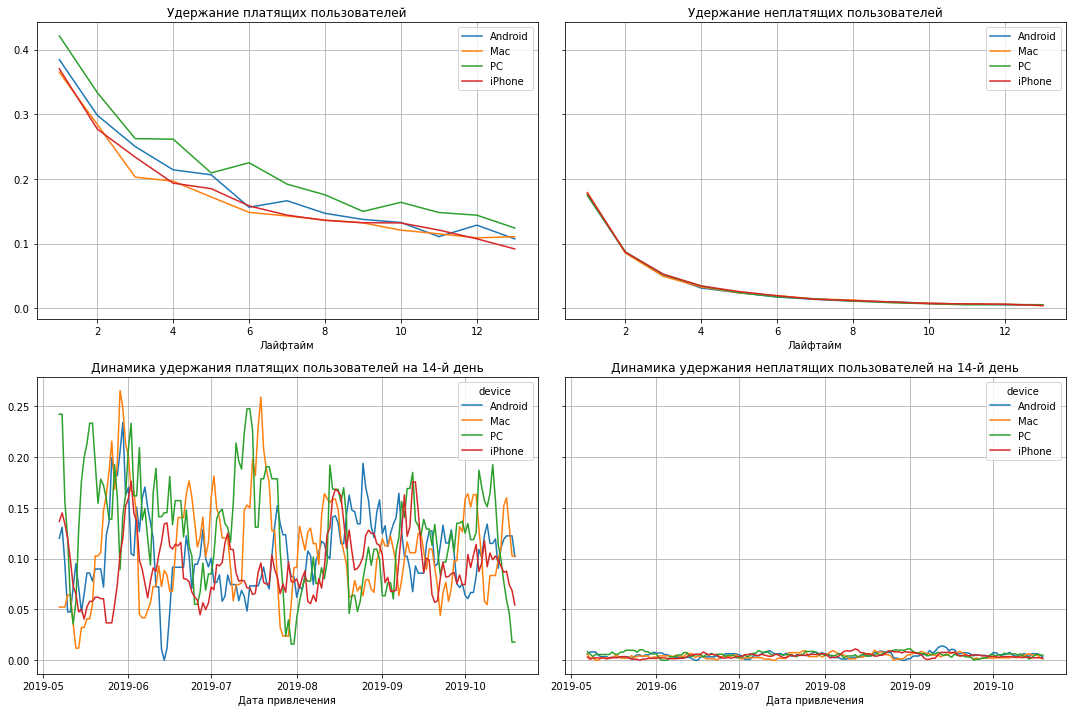

In [40]:
#Рассчитаем удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days)

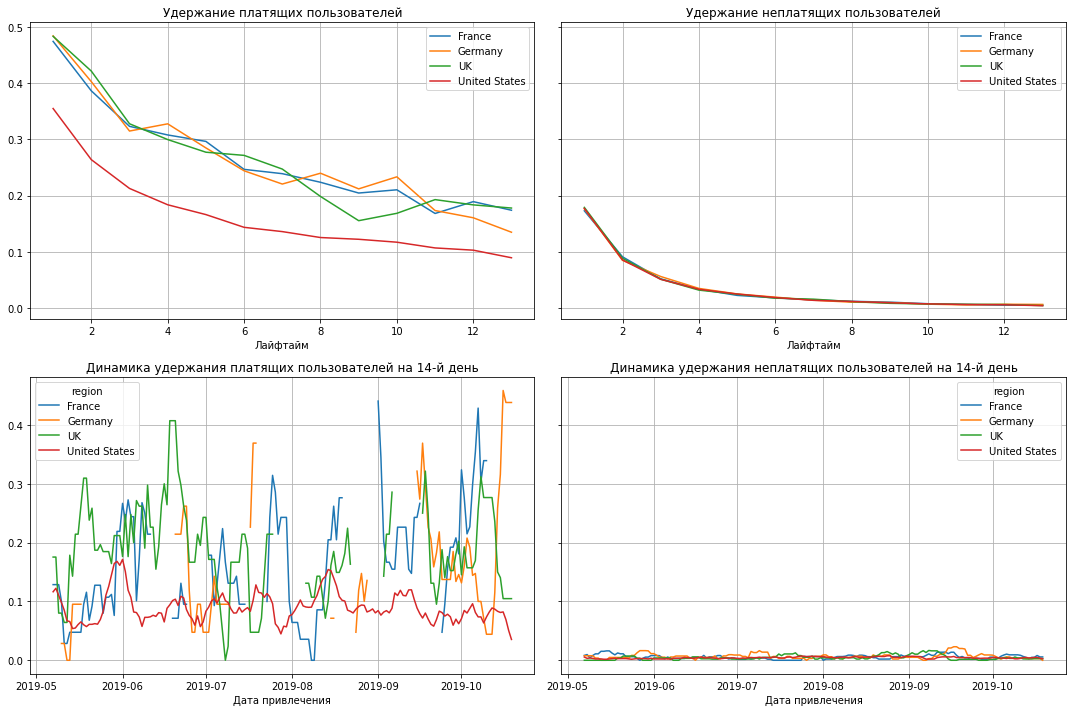

In [41]:
#Рассчитаем удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days)

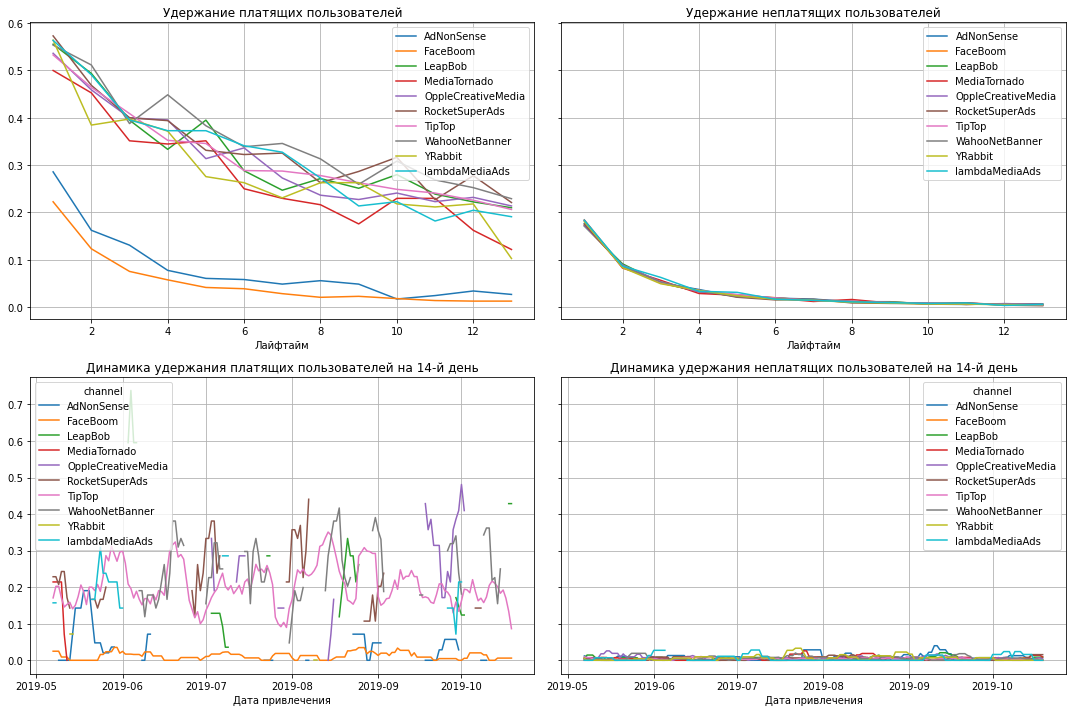

In [42]:
#Рассчитаем удержание с разбивкой по каналам привлечения

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)
retention_grouped = retention_grouped.query('channel != "organic"')
retention_history = retention_history.query('channel != "organic"')
plot_retention(retention_grouped, retention_history, horizon_days)

Удержание пользователей Iphone и Mac одинаково с другими устройствами.
А вот удержание по странам отличает США от всех других стран. Примерно на 10% пользователи из этой страны стабильно плохо удерживаются.
В разрезе по каналам рекламы, хуже всего удерживаются пользователи каналов "AdNonSense" и "FaceBoom". Видимо в этом и есть причина плохой окупаемости в США.

**Вывод**

    Общая картина по инвестициям в рекламу следующая:

Реклама не окупается в целом. Но затраты на привелечение пользователя увеличиваются. 
Показатели LTV достаточно стабильны, наблюдается некая закономерность в падении этого показателя в конце каждого месяца. 
Больше всего страдает окупаемость в США, и денежных средств вложенных в рекламу именной в этой стране больше всего.
Лучше всего окупаются пользователи, использующие приложение на PC, все остальные устройства не окупаются вообще.
Больше всего денег приносят пользователи из каналов "lambdaMediaAds" и "TipTop", при этом рекламные вложения в первый источник стабильно окупаются, а из второго нет. Кроме того, вложения в "TipTop" увеличивались каждый месяц. Также не окупились вложения в пользователей из каналов "FaceBoom" и "AdNonSense", но затраты на рекламу там были стабильны и на протяжении полугода не менялись.

    С конвертируемостью и удержанием пользователей ситуация следующая:

Пользователи из США конвертируются намного лучше пользователей из других стран. 
То же самое можно сказать про пользователей с Mac и Iphone. 
Кроме того, пользователи из канала "Faceboom" конвертировались лучше всех и стабильнее.
Удержание пользователей Iphone и Mac одинаково с другими устройствами. А вот удержание по странам отличает США от всех других стран. Примерно на 10% пользователи из этой страны стабильно плохо удерживаются. В разрезе по каналам рекламы, хуже всего удерживаются пользователи каналов "AdNonSense" и "FaceBoom". Видимо в этом и есть причина плохой окупаемости в США.

## 6 Общий вывод

Пользователи США пришедшие из канала "FaceBoom" стабильно конвертируются, но практически не удерживаются на 14 день. Такая же ситуация с каналом "AdNonSense" и жителями Европы. Возможно следует исследовать поведение этих пользователей. Вероятно люди пришедшие с этих каналов являются платежеспособной аудиторией, но более занятой, и спустя некоторое время не нуждаются в приложении. 

Кроме того, не окупаются затраты на рекламу в канал "TipTop", там вероятнее аудитория не такая платежеспособная и тот факт, что инвестиции в рекламу увеличиваются каждый месяц, но при этом конверсия не увеличивается, говорит о том, что возможно стоит уменьшить инвестиции в данный канал. 

Лучше всех из стран Европы окупается Великобритания, а также пользователи, пришедшие из канала "lambdaMediaAds". Возможно стоит сделать упор именно на эту страну и этот канал. 

Такой канал как "OppleCreativeMedia" имеет низкую конверсию, а окупаемость уступает остальным каналам, пересекшим уровень окупаемости, возможно стоит отказаться от рекламных инвестиций в этот канал привелечения пользователей. Также низкая конверсия замечена у пользователей из каналов "YRabbit", "MediaTornado", "LeapBob", поэтому при серьезной оптимизации инвестиций в рекламу, возможно это первые кандидаты на исключение.  

В разрезе устройств, лучше всего ведет себя PC, это единственное устройство, которое окупилось. Возможно пользователям других устройств чего-то не хватает, вследствие чего удержание по другим устройствам уступает PC.
